In [66]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd

In [68]:
import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [69]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, load_only
from sqlalchemy import create_engine, func, inspect, and_

In [70]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [71]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [72]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [73]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [74]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [75]:
# let's get the date a year ago from now
now = datetime.datetime.now()
dt = relativedelta(years=1)
year_ago = now - dt
year_ago_str = year_ago.strftime("%Y-%m-%d")
print(year_ago_str)

2017-09-04


In [76]:
# let's check which colums we have
columns = [m.key for m in Measurement.__table__.columns]
print(columns)

['id', 'station', 'date', 'prcp', 'tobs']


In [77]:
# let's check if there's data
query = session.query(Measurement)

# The instructions in the Readme say to only query
# date and precipation data. This is certainly possible, though I doubt
# it makes sense in the ORM paradigm. But here we go:

rain = query.filter(Measurement.date >= year_ago_str).\
    options(load_only("date", "prcp")).all()
print(len(rain))

0


In [78]:
# Oh that's not good. Let's see what the last available date is
rain = query.order_by(Measurement.date.desc()).all()
print(rain[0].date)

2017-08-23


In [79]:
# Okay, back to square one, let's take data from another start point
fake_today = parse("2017-08-14")
dt = relativedelta(years=1)
year_ago = fake_today - dt
year_ago_str = year_ago.strftime("%Y-%m-%d")
print(year_ago_str)

2016-08-14


In [116]:
# now get the data
rain = query.order_by(Measurement.date).filter(and_(Measurement.date >= year_ago_str, 
                    Measurement.date < fake_today))
df = pd.read_sql(rain.options(load_only("date","prcp")).statement,session.bind)
del df['id']
df.head(10)

,date,prcp
0,2016-08-14,0.00
1,2016-08-14,0.17
2,2016-08-14,0.00
3,2016-08-14,0.10
4,2016-08-14,0.75
5,2016-08-15,0.00
6,2016-08-15,0.17
7,2016-08-15,NaN
8,2016-08-15,NaN
9,2016-08-15,0.00


In [81]:
# great... we have multiple measurements per day, and we have nans. Let's clean
# up and take the average
df.fillna(0.0,inplace=True)
dfg = df.groupby("date").mean()
dfg.rename(columns={"prcp":"precipitation"},inplace=True)
dfg.head(5)

,precipitation
date,
2016-08-14,0.204000
2016-08-15,0.192857
2016-08-16,0.155714
2016-08-17,0.087143
2016-08-18,0.031429


<IPython.core.display.Javascript object>


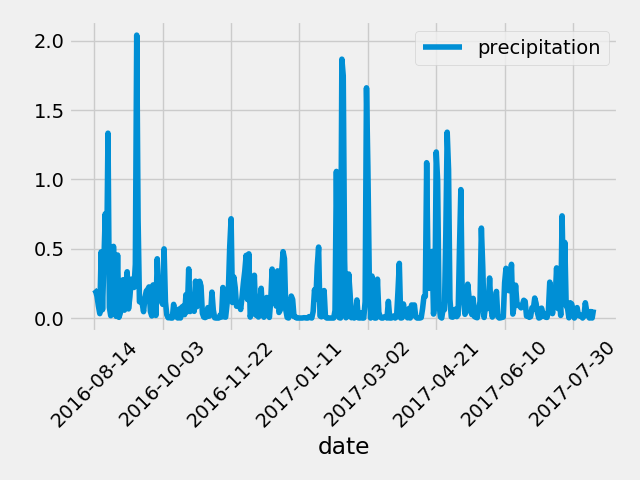

In [82]:
ax = dfg.plot(rot=45)
plt.tight_layout()

# use this to get rid of the labels
# labels = [item.get_text() for item in ax.get_xticklabels()]
# empty_string_labels = ['']*len(labels)
#_ = ax.set_xticklabels(empty_string_labels)

In [140]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dfg.describe()

,precipitation
count,366.000000
mean,0.175750
std,0.299718
min,0.000000
25%,0.008929
50%,0.070833
75%,0.204000
max,2.380000


In [83]:
# How many stations are available in this dataset?
query = session.query(Station).all()
print(len(query))

9


In [84]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station))\
      .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [85]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
xstation = 'USC00519281'
query = session.query(Measurement)
temp = query.order_by(Measurement.date).filter(and_(Measurement.date >= year_ago_str, 
                    Measurement.date < fake_today)).filter(Measurement.station == xstation)
df = pd.read_sql(temp.statement,session.bind)
df.rename(columns={'tobs':'temperature'},inplace=True)
del df['prcp']
del df['id']
del df['station']
df.set_index('date',inplace=True)
df.head(5)

,temperature
date,
2016-08-14,76.0
2016-08-15,75.0
2016-08-16,74.0
2016-08-17,82.0
2016-08-18,80.0


<IPython.core.display.Javascript object>


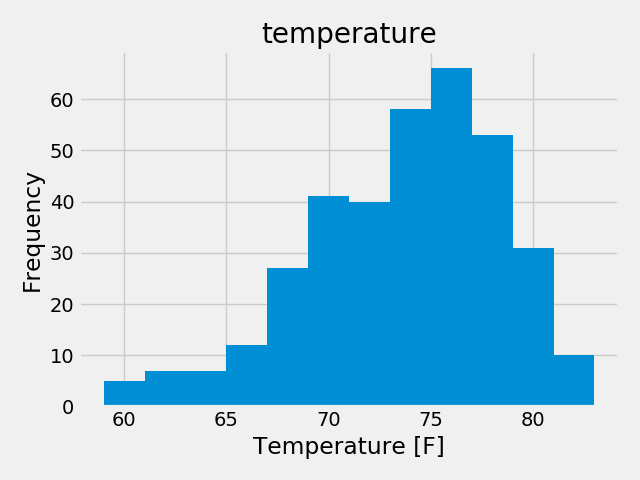

In [114]:
df.hist(bins=12)
plt.xlabel("Temperature [F]")
plt.ylabel("Frequency")
plt.tight_layout()

In [53]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [88]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-06-30'
end_date = '2017-07-15'
print(calc_temps(start_date,end_date))

[(69.0, 78.07070707070707, 87.0)]


<IPython.core.display.Javascript object>


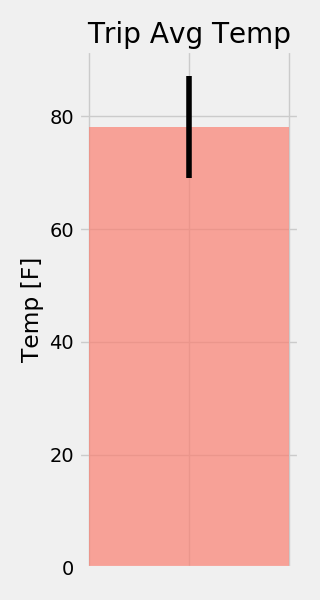

In [113]:
res = calc_temps(start_date,end_date)[0]
ind = [0]
mean = [res[1]]
std = [(res[1]-res[0],res[2]-res[1])]
plt.figure(figsize=(3.2,6))
plt.bar(ind, mean, width=1,yerr=std,color='salmon',alpha=0.7)
plt.ylabel("Temp [F]")
plt.title("Trip Avg Temp")
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)

plt.tight_layout()

In [131]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,
                     Station.elevation,func.sum(Measurement.prcp)).filter(and_(Measurement.date >= start_date,\
            Measurement.date < end_date))\
            .join(Station,Station.station==Measurement.station)\
            .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(rain)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.9700000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.8400000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.29000000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.2), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


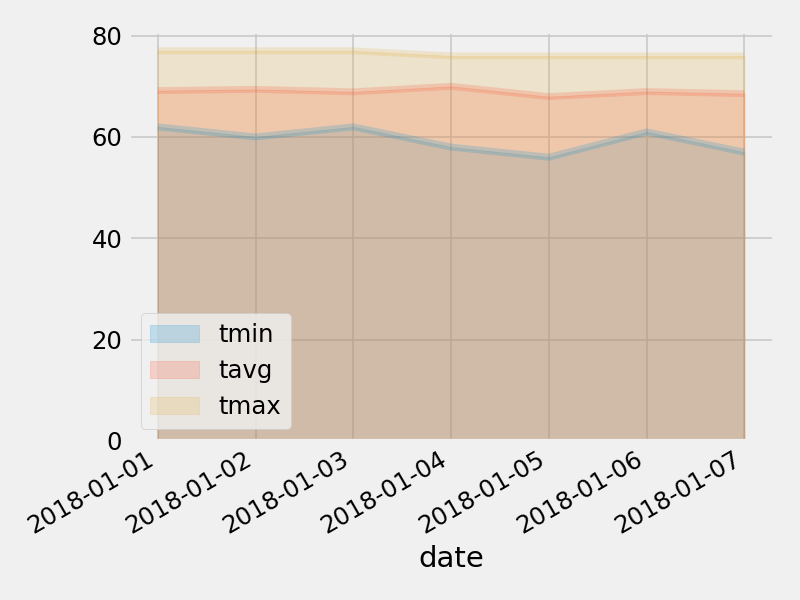

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
